In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
warnings.filterwarnings("ignore")
 
import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy, load_ticker_ts_df

In [8]:
START_DATE = "2020-01-01"
END_DATE = "2023-12-24"
tickers = ["AAPL", "MSFT", "AMZN", "TSLA", "GOOG", "XOM", "META", "NVDA", "PEP", "AVGO", "ADBE", "COST", "PYPL", 
           "AMD", "QCOM", "INTC", "TXN", "CHTR", "TMUS", "ISRG", "SBUX", "AMGN", "INTU", "ADP", "CSX", "ADI", "MU", 
           "ZM", "MAR", "GILD", "MELI", "WDAY", "PG", "PANW", "REGN", "RCL", "BKNG", "JNJ", "ADSK", "KLAC", "BAC"]

tickers_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
tickers_rets_df = tickers_df.dropna(axis=1).pct_change().dropna()
tickers_rets_df = (1 + tickers_rets_df).cumprod() - 1

tickers_rets_df.head(5)

,AAPL,MSFT,AMZN,TSLA,GOOG,XOM,META,NVDA,PEP,AVGO,...,WDAY,PG,PANW,REGN,RCL,BKNG,JNJ,ADSK,KLAC,BAC
2020-01-03 00:00:00,-0.009722,-0.012452,-0.012139,0.029633,-0.004907,-0.008039,-0.005291,-0.016006,-0.001399,-0.025435,...,0.005852,-0.006726,0.006032,-0.011223,-0.008615,-0.004387,-0.011577,-0.015333,-0.019116,-0.020763
2020-01-06 00:00:00,-0.001831,-0.009899,0.002566,0.049458,0.019629,-0.000423,0.013443,-0.011879,0.002429,-0.026893,...,0.012122,-0.005348,0.020602,-0.004312,-0.022428,-0.013101,-0.012811,-0.003780,-0.041190,-0.022166
2020-01-07 00:00:00,-0.006526,-0.018926,0.004663,0.090178,0.018993,-0.008604,0.015635,0.000083,-0.013327,-0.030243,...,0.032784,-0.011506,0.026464,-0.000589,-0.031266,-0.003148,-0.006782,-0.001757,-0.033576,-0.028620
2020-01-08 00:00:00,0.009455,-0.003300,-0.003182,0.143820,0.027023,-0.023554,0.025932,0.001959,-0.008246,-0.042340,...,0.067180,-0.007293,0.013423,0.024294,-0.018047,-0.005630,-0.006919,0.011287,-0.032317,-0.018799
2020-01-09 00:00:00,0.030897,0.009152,0.001602,0.118719,0.038366,-0.016079,0.040614,0.012963,-0.007584,-0.050033,...,0.071778,0.003565,0.019795,0.027106,-0.005421,0.004681,-0.003973,0.021881,-0.038780,-0.017116


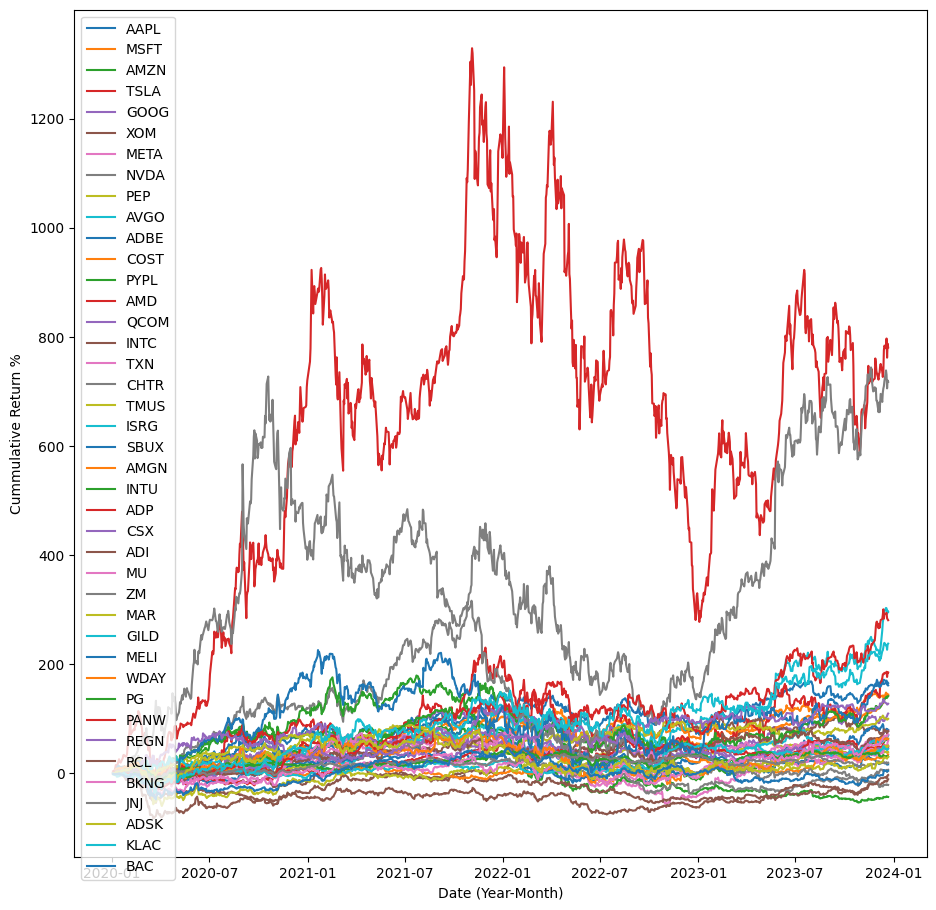

In [10]:
plt.figure(figsize=(11, 11))
for ticker in tickers_rets_df.columns:
    plt.plot(tickers_rets_df.index, tickers_rets_df[ticker] * 100.0, label=ticker)
 
plt.xlabel("Date (Year-Month)")
plt.ylabel("Cummulative Return %")
plt.legend()
plt.show()

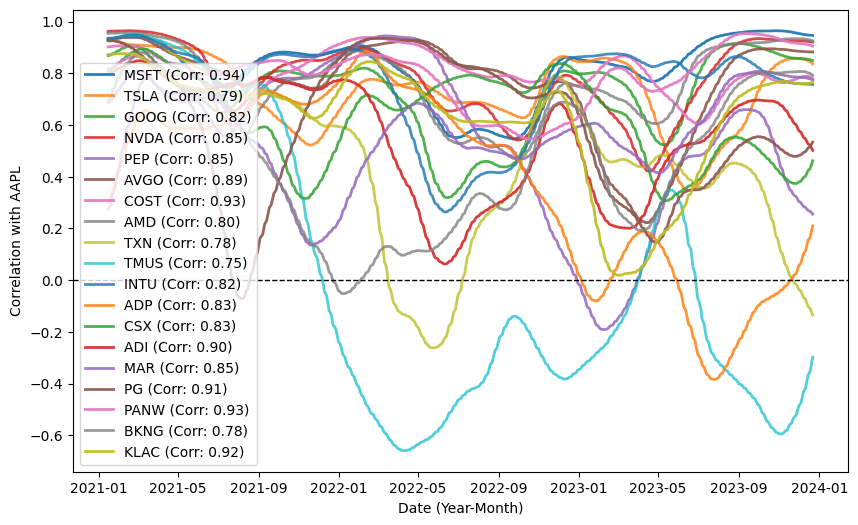

In [12]:
TARGET = "AAPL"
MA_WINDOW = 24 #Macroaxis Window
ARB_WINDOW = MA_WINDOW * 10
plt.figure(figsize=(10, 6))

corr_ticks = []
LEADS = []
 
for ticker in tickers:
    if ticker == TARGET:
        continue
    correlation = tickers_df[ticker].corr(tickers_df[TARGET])
    if abs(correlation) < 0.75:
        continue

    LEADS.append(ticker)

    corr_ts = tickers_df[ticker].rolling(ARB_WINDOW).corr(tickers_df[TARGET])
    plt.plot(
        tickers_df.index,
        corr_ts.rolling(MA_WINDOW).mean(),
        label=f"{ticker} (Corr: {correlation:.2f})",
        alpha=correlation,
        linewidth=2,
    )
    corr_ticks.append(ticker)

plt.axhline(y=0, color="k", linestyle="--", linewidth=1)
 
plt.xlabel("Date (Year-Month)")
plt.ylabel("Correlation with AAPL")
plt.legend()
plt.show()

In [8]:
def cleaned_data(data_map):
    TS_DAYS_LENGTH = (pd.to_datetime(END_DATE) -
                      pd.to_datetime(START_DATE)).days
    data_cleaned = {}

    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
    for ticker, data in data_map.items():
        if data is None or len(data) < (TS_DAYS_LENGTH / 2):
            # We cannot handle shorter TSs
            continue

        if len(data) > TS_DAYS_LENGTH:
            # Normalize to have the same length (TS_DAYS_LENGTH)
            data = data[-TS_DAYS_LENGTH:]

        # Reindex the time series to match the date range and fill in any blanks (Not Numbers)
        data = data.reindex(date_range)
        data['Adj Close'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['Adj Close'].interpolate(method='linear', inplace=True)
        data['Adj Close'].fillna(method='pad', inplace=True)
        data['Adj Close'].fillna(method='bfill', inplace=True)

        assert not np.any(np.isnan(data['Adj Close'])) and not np.any(
            np.isinf(data['Adj Close']))

        data_cleaned[ticker] = data

    return data_cleaned

def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    tickers = list(tickers_ts_map.keys())
    n = len(tickers)

    # Extract 'Adj Close' prices into a matrix (each column is a time series)
    adj_close_data = np.column_stack(
        [tickers_ts_map[ticker]['Adj Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))

    # Calculate cointegration p-values for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = coint(adj_close_data[:, i], adj_close_data[:, j])
        pvalue_matrix[i, j] = result[1]
    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j])
             for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]

    return pvalue_matrix, pairs

In [9]:
crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD',
                       'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 'RVN-USD', 'SXP-USD', 'BTCB-USD']
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB',  'CFG',
               'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 'WAL', 'PACW', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC', 'HOMB']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100',
                  '^RUT', '^VIX', '^TNX']

START_DATE = '2021-01-01'
END_DATE = '2023-10-31'

universe_tickers = crypto_forex_stocks + bank_stocks + global_indexes
universe_tickers_ts_map = {ticker: load_ticker_ts_df(
    ticker, START_DATE, END_DATE) for ticker in universe_tickers}

In [10]:
uts_cleaned = cleaned_data(universe_tickers_ts_map)
uts_cleaned['JPM'].shape, uts_cleaned['BTC-USD'].shape

((1034, 6), (1034, 6))

In [11]:
P_VALUE_THRESHOLD = 0.02
pvalues, pairs = find_cointegrated_pairs(
    uts_cleaned, p_value_threshold=P_VALUE_THRESHOLD)

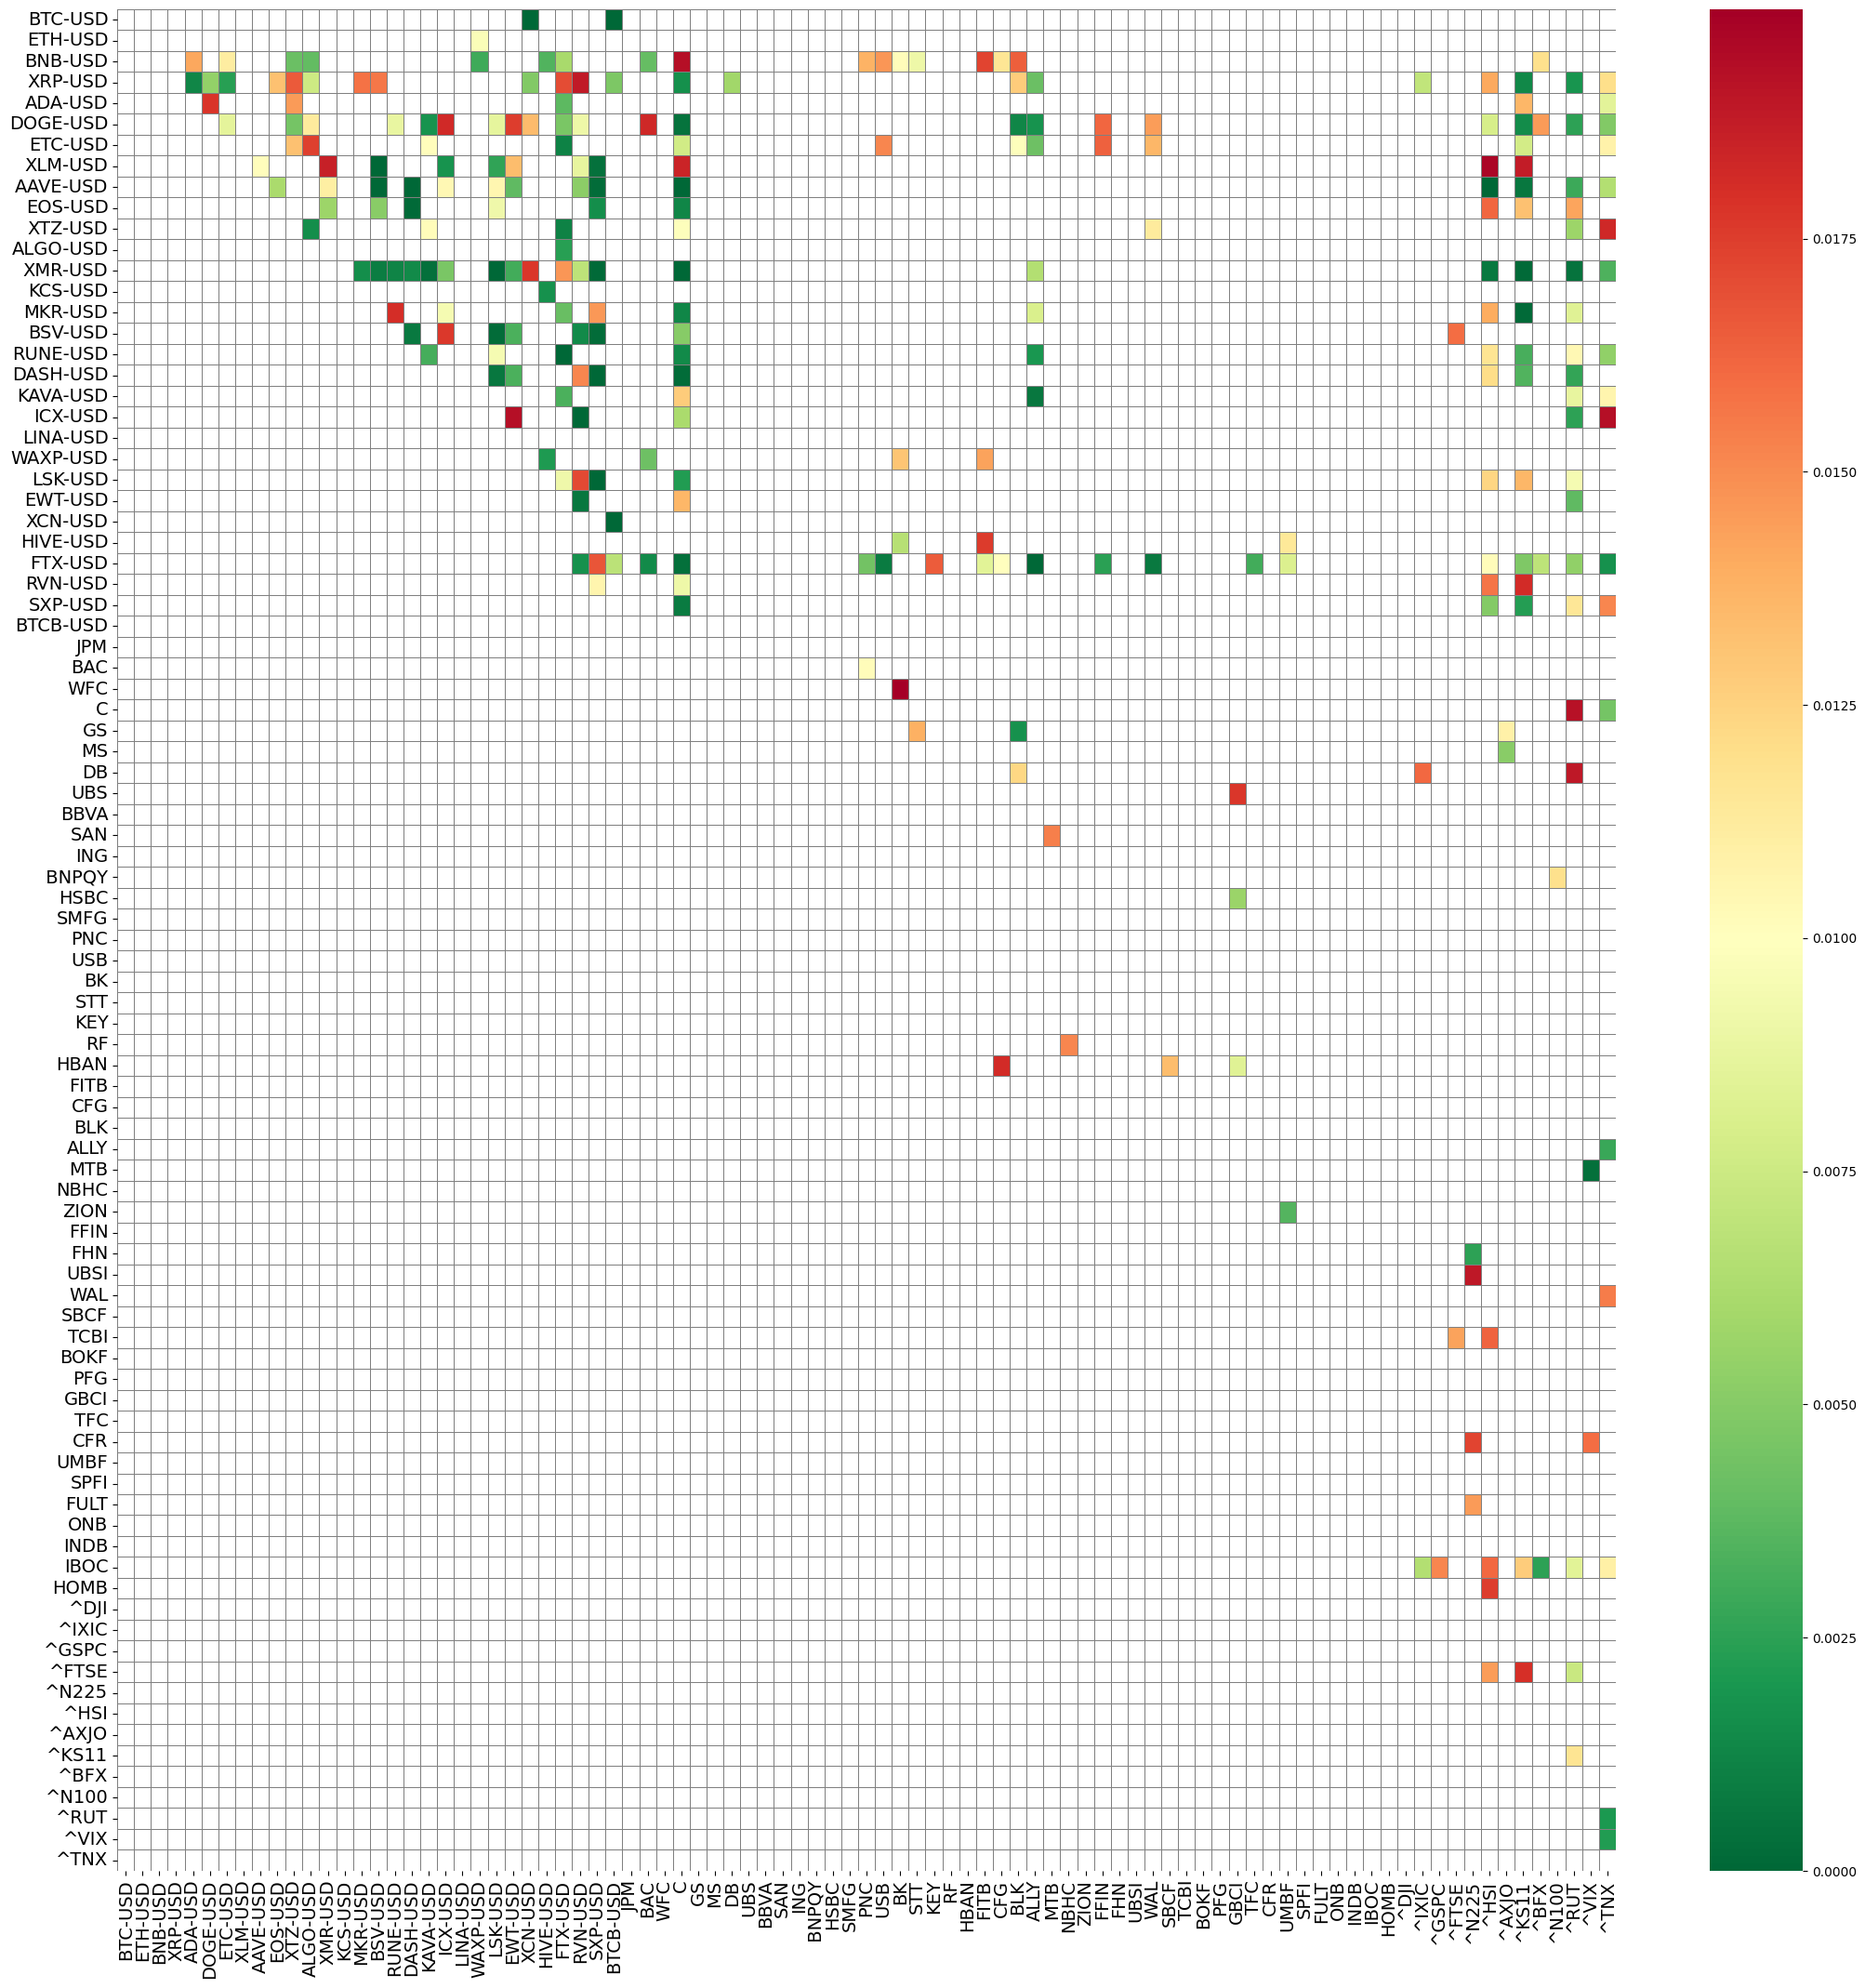

In [13]:
import seaborn as sns

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=uts_cleaned.keys(),
                      yticklabels=uts_cleaned.keys(), cmap='RdYlGn_r',
                      mask=(pvalues > (P_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
plt.show()

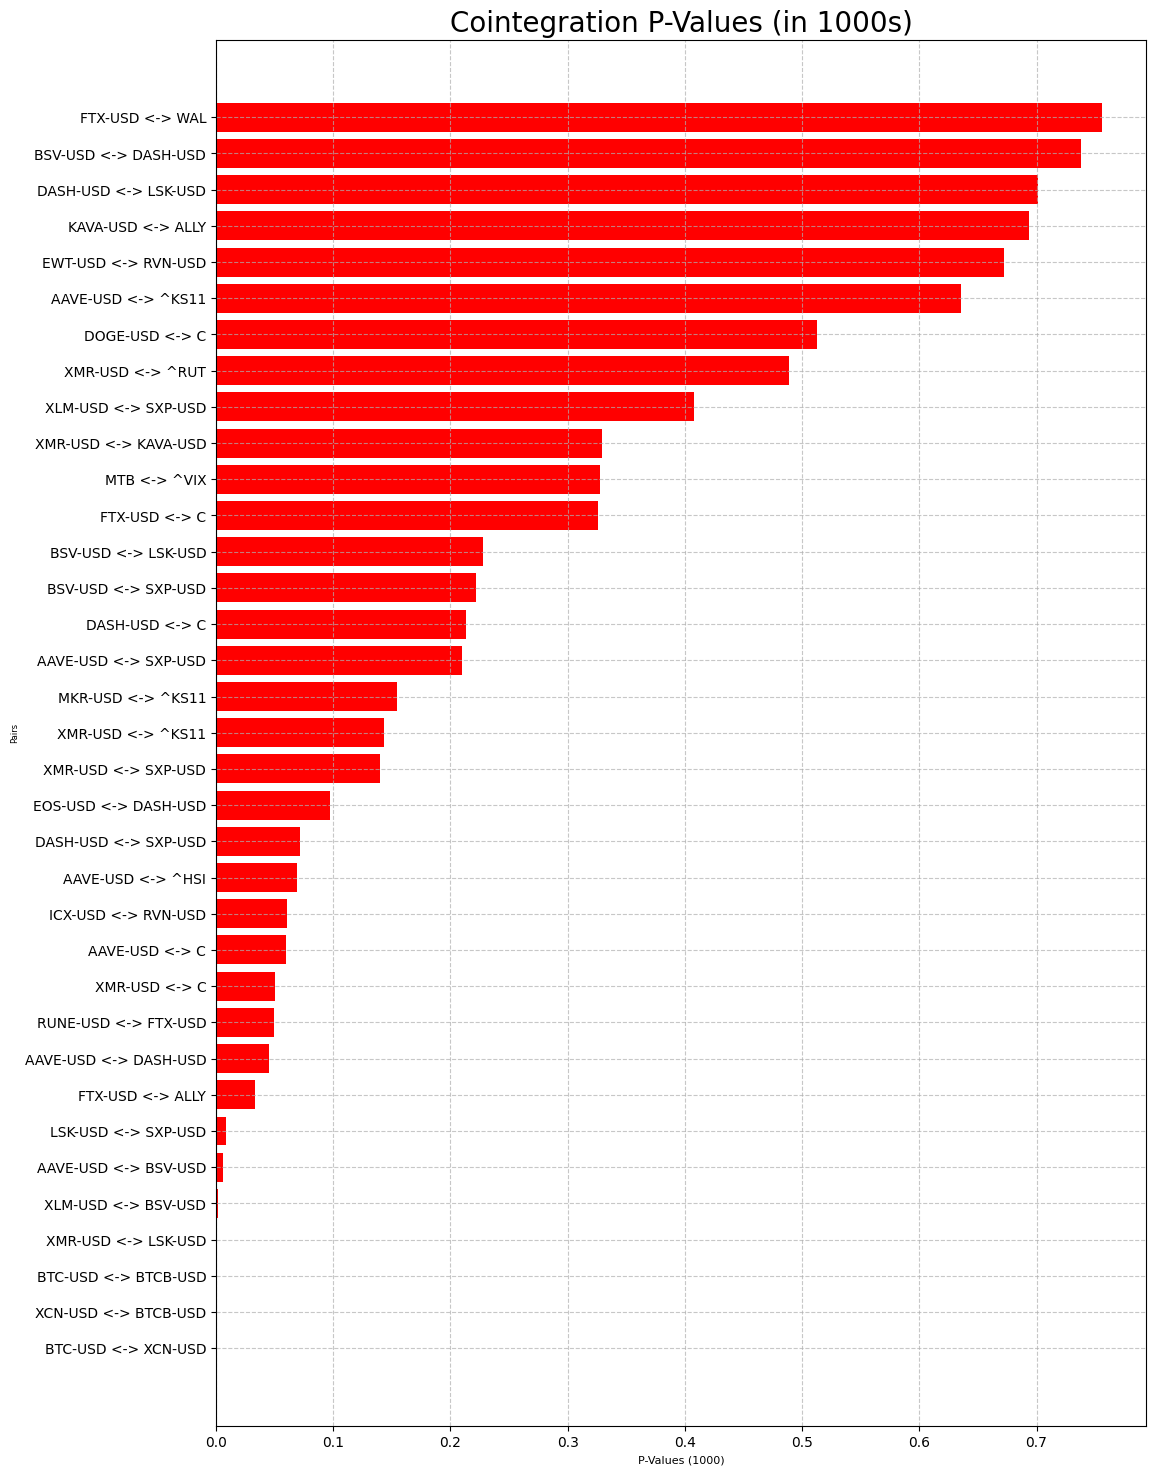

In [14]:
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sorted_pairs = sorted_pairs[0:35]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sorted_pairs])

plt.figure(figsize=(12, 18))
plt.barh(sorted_pairs_labels,
         pairs_p_values, color='red')
plt.xlabel('P-Values (1000)', fontsize=8)
plt.ylabel('Pairs', fontsize=6)
plt.title('Cointegration P-Values (in 1000s)', fontsize=20)

plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

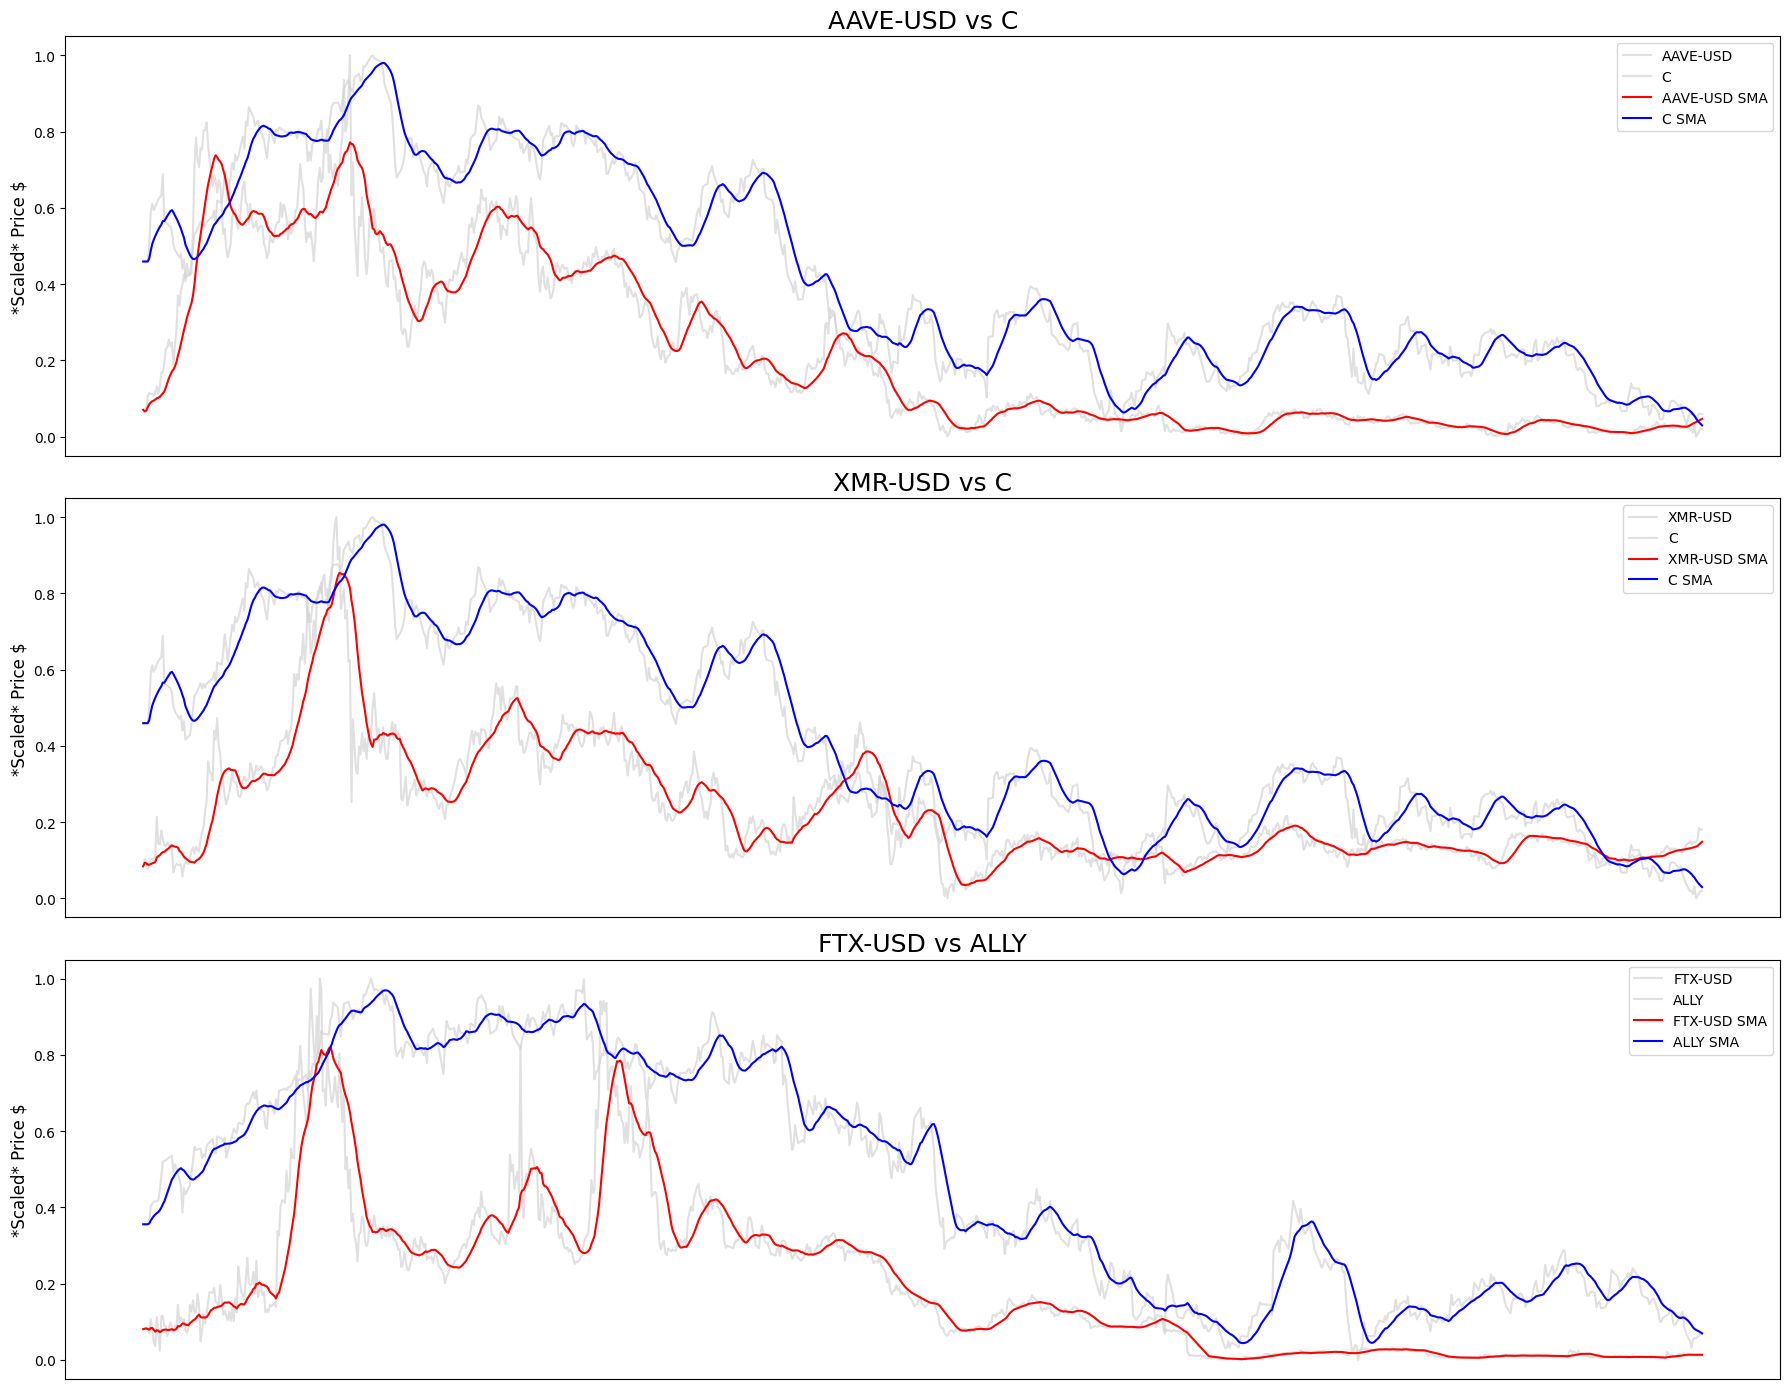

In [15]:
from sklearn.preprocessing import MinMaxScaler

ticker_pairs = [("AAVE-USD", "C"), ("XMR-USD", "C"), ("FTX-USD", "ALLY")]

fig, axs = plt.subplots(3, 1, figsize=(18, 14))
scaler = MinMaxScaler()

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        uts_cleaned[ticker1]['Adj Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        uts_cleaned[ticker2]['Adj Close'].values.reshape(-1, 1))

    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)

    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()

    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')

    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()